# Setup

## Imports and Configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import json
from datetime import datetime
import functools
import matplotlib.pyplot as plt
import seaborn as sb
from anndata import AnnData
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

palette = "tab20"


def construct_file(sample, slide, date=None, timestamp=None,
                   panel_id="TUQ97N", prefix="output-XETG00189",
                   project_owner="EA", run="CHO-001", directory=None):
    """Construct file path from information."""
    if isinstance(sample, str):
        sample = [sample]
    if "outputs" not in directory and os.path.exists(
            os.path.join(directory, "outputs")):
        directory = os.path.join(directory, "outputs")
    print(directory)
    panel_id, prefix, project_owner, slide, date, timestamp = [
        [x] * len(sample) if isinstance(x, str) else list(x) if x else x
        for x in [panel_id, prefix, project_owner, slide, date, timestamp]]
    run = [run] * len(sample) if isinstance(run, (str, int, float)) else run
    block = ["-".join(i) for i in zip(sample, panel_id, project_owner)]
    fff = [f"{prefix[i]}__{slide[i]}__{block[i]}" for i in range(len(sample))]
    if date is None or timestamp is None:
        for i, x in enumerate(fff):  # iterate current file stems
            ddd = os.path.join(directory, panel_id[i], run[i])
            print(ddd)
            matches = sum([x in d for d in os.listdir(ddd)])
            if  matches != 1:
                raise ValueError(f"{x} found in 0 or multiple file paths",
                                 f"\n\n{os.listdir(ddd)}")
            fff[i] = os.path.join(ddd, np.array(os.listdir(ddd))[np.where([
                x in d for d in os.listdir(ddd)])[0][0]])  # find match
    else:
        fff = [os.path.join(directory, panel_id[i], run[i],
                            f"{x}__{date[i]}__{timestamp[i]}")
               for i, x in enumerate(fff)]
    return fff

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options

In [2]:
# Column Names
col_sample_id_original = "Sample ID"
col_sample_id = "Sample"
col_subject = "Patient"
col_batch = "Slide"
col_path = "file_path"
# col_date_time, col_date = "Date Sectioned", "Date"
col_date_time, col_date = None, None
col_inflamed, col_stricture = "Inflamed", "Stricture"
col_condition = "Condition"
meta_rn = {"Name": col_subject, "Slide ID": col_batch,
           "Inflammation Status": col_inflamed}

# Directories & Metadata
# Replace manually or mirror my file/directory tree in your home
include_stricture = True
run = "CHO-001"
samples = ["50452A", "50452B", "50452C"]
# samples = ["50452A", "50452B"]
# samples = ["50452A", "50452B", "50452C", "50564A4", "50618B5"]
# run = ["CHO-001"] * 3 + ["CHO-002"] * 3
panel_id = "TUQ97N"
prefix = "output-XETG00189"
project_owner = "EA"
ddu = os.path.expanduser("~")
ddl = "/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library"
ddd = os.path.join(ddl, "outputs", panel_id)
panel = os.path.join(ddu, "projects/senescence/ProposedGenePanel.xlsx")
file_ann = os.path.join(ddu, "corescpy/examples/annotation_guide.xlsx")

# Input/Output Options
reload = True
out_dir = os.path.join(ddd, "nebraska")  # set to None to avoid saving
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Read Metadata & Other Information
annot_df = pd.read_excel(file_ann)
metadata = pd.read_excel(os.path.join(ddl, "Xenium_Samples_02092024.xlsx"),
                         dtype={"Slide ID": str})
metadata = metadata.rename(meta_rn, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_original).loc[
        samples].reset_index()

# Processing & Clustering Options
resolution = 0.5
min_dist = 1
n_comps = 20
# col_qscore = ?
# custom_thresholds = {col_qscore: [, None]}
custom_thresholds = None
genes_subset = list(annot_df.iloc[:, 0])
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[30, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None],
              custom_thresholds=custom_thresholds,
              kws_scale=dict(max_value=10, zero_center=True))
kws_umap = dict(min_dist=min_dist, method="rapids") if gpu is True else dict(
    min_dist=min_dist)
kws_cluster = dict(use_gpu=gpu, kws_umap=kws_umap, kws_neighbors=None,
                   use_highly_variable=False, n_comps=n_comps,
                   genes_subset=genes_subset, resolution=resolution)
# kws_subcluster = dict(use_gpu=gpu, kws_umap=dict(min_dist=0.3),
#                       kws_neighbors=None, use_highly_variable=False,
#                       n_comps=n_comps, genes_subset=genes_subset,
#                       method_cluster="leiden", resolution=0.5)
kws_subcluster = dict(method_cluster="leiden", resolution=0.5)

# Revise Metadata & Construct Variables from Options
if col_stricture not in metadata.columns:
    metadata.loc[:, col_stricture] = metadata["Sample Location"].apply(
        lambda x: "Stricture" if "stricture" in x.lower() else "None")
metadata.loc[:, col_condition] = metadata.apply(
    lambda x: "Stricture" if "stricture" in x[col_stricture].lower() else x[
        col_inflamed].capitalize() , axis=1)
if col_date_time:
    metadata.loc[:, col_date] = metadata[col_date_time].apply(
        lambda x: datetime.strftime(x, "%Y%m%d"))
    dates = list(metadata[col_date])
else:
    dates = None
metadata.loc[:, col_sample_id] = metadata.apply(
    lambda x: f"{x[col_condition]}-{x[col_sample_id_original]}" , axis=1)
metadata = metadata.set_index(col_sample_id)
metadata.loc[:, col_path] = construct_file(
    list(metadata[col_sample_id_original]), list(metadata[col_batch]),
    dates, panel_id=panel_id, prefix=prefix,
    project_owner=project_owner, run=run, directory=ddl)
col_cell_type = "Annotation"
file_path_dict = dict(zip(metadata.index.values, metadata["file_path"]))
kws_init = dict(col_batch=col_batch, col_subject=col_subject,
                col_sample_id=col_sample_id, col_cell_type=col_cell_type)

# Annotation File
col_assignment = "Bin"
assign = pd.read_excel(file_ann, index_col=0).dropna(subset=col_assignment)
sources = assign[col_assignment].unique()
rename = dict(zip(sources, [" ".join([i.capitalize() if i and i[
    0] != "(" and not i.isupper() and i not in [
        "IgG", "IgA"] else i for i in x.split(" ")]) if len(x.split(
            " ")) > 1 else x for x in [re.sub("glia", "Glia", re.sub(
                "_", " ", j)) for j in sources]]))
assign.loc[:, col_assignment] = assign[col_assignment].replace(rename)
assign = assign.rename_axis("Gene")
marker_genes_dict = dict(assign.reset_index().groupby(col_assignment).apply(
    lambda x: list(pd.unique(x.Gene))))  # to marker dictionary

# Subset if Desired
if include_stricture is False:
    metadata = metadata[metadata.Stricture != "Stricture"]
metadata

# Genes
# genes = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]
# cell_types = ["ILC3", "LTi-like NCR+ ILC3", "LTi-like NCR- ILC3",
#               "ILCP", "Macrophages", "Stem cells"]
# palette = ["r", "tab:pink", "m", "b", "tab:brown", "cyan"]
# High in inf. vs. un
# OSM
# IL13
# IL1B
# IL6
# TNF
# S100A8
# S100A9
# ------------------------------
# High in stricture vs inf/un
# PDGFRA
# IL6ST
# PTPN1
# IFNG

/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001


,Sample ID,Patient,Status,Project,Sample Location,Inflamed,Slide,GRID ID,Procedure Date,Age,Sex,Race,Hispanic,Diagnosis,Project.1,Procedure,Disease Status,Date Collected,Date Sectioned,Date of Hybridization,Storage in 4C,Created By,Created,Storage Status,Sample Location.1,Storage Row,Storage Col,Checked Out By,Stricture,Condition,file_path
Sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Uninflamed-50452A,50452A,50452,Available,scRNA & Spatial,Terminal Ileum,uninflamed,0010700,1011335,2023-12-04,69,female,white,NO,Crohn's Disease,Helmsley-Senescence,Resection,Active,NaN,2024-01-22 15:25:38,2024-01-23 15:25:58,YES,ksenija sabic,2024-02-06 15:26:47.887,Not in storage,NaN,NaN,NaN,NaN,None,Uninflamed,/mnt/cho_lab/disk2/elizabeth/data/shared-xeniu...


# Data

## Loading

In [3]:
%%time

# Load Spatial Data
suff = str(f"res{re.sub('[.]', 'pt', str(resolution))}_dist"
           f"{re.sub('[.]', 'pt', str(min_dist))}_npc{n_comps}")  # file end
selves, paths_he, file_mks, out_files = [], [], [], []
for x in metadata.index.values:
    self = cr.Spatial(metadata.loc[x][col_path], library_id=x, **kws_init)
    for i in metadata:  # add metadata for subject
        self.rna.obs.loc[:, i] = str(metadata.loc[x][i])  # add metadata
    selves += [self]
    paths_he += [os.path.join(metadata.loc[x][
        col_path], "aux_outputs/image_he.ome.tif")]  # H&E paths
        # out_files += [os.path.join(out_dir, f"{x}.zarr")]
    if out_dir is not None:
        out_files += [os.path.join(out_dir, f"{x}__{suff}.zarr")]
    file_mks += [os.path.join(out_dir, f"{x}__{suff}_markers.csv")]

# Reload Processed & Clustered Data (Optionally)
if reload is True:
    for i, s in enumerate(selves):
        mks = file_mks[i] if os.path.exists(file_mks[i]) else None
        s.update_from_h5ad(file=out_files[i], file_path_markers=mks)
        print(s.adata)



<<< INITIALIZING SPATIAL CLASS OBJECT >>>



<<< INITIALIZING OMICS CLASS OBJECT >>>

Unused keyword arguments: {'library_id': 'Uninflamed-50452A', 'visium': False}.




col_gene_symbols="gene_symbols"
col_cell_type="Annotation"
col_sample_id="Sample"
col_batch="Slide"
col_subject="Patient"
col_condition=None
col_num_umis=None



key_control=None
key_treatment=None
INFO     reading                                                                                                   
         /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001/output-XETG00189__0010700__
         50452A-TUQ97N-EA__20240126__205019/cell_feature_matrix.h5                                                 


dsfasfda AnnData object with n_obs × n_vars = 333825 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'


Cell Counts: Initial


Observations: 333825



Gene Counts: Initial

Empty DataFrame
Columns: [index, gene_ids, feature_types, genome]
Index: []





 SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundar

## Plot

In [ ]:
if reload is True:
    for i, s in enumerate(selves):
        s.plot_spatial(color="leiden")
        # s.plot_spatial(color=col_cell_type)

# Annotation & Sub-Clustering

In [ ]:
for s in selves:
    _ = s.cluster(**kws_cluster)
    _ = s.annotate_clusters(file_ann, col_cell_type="leiden",
                            col_annotation=col_cell_type,
                            col_assignment=col_assignment)  # annotate & write
    s.plot_spatial(color=col_cell_type)

In [ ]:
# cat_epi = ["BEST2+ Goblet Cell", "BEST4+ Epithelial", "EC Cells (NPW+)",
#            "EC Cells (TAC1+)", "Enterocyte", "Epithelial", "Goblet Cell",
#            "I Cells (CCK+)", "Paneth", "D Cells (SST+)",
#            "Stem Cells", "N Cells (NTS+)", "K Cells (GIP+)",
#            # "Colonocyte",
#            "L Cells (PYY+)", "Tuft", "Microfold Cell"]
# cat_epi = list(np.array()[np.where(["epithelial" in x.lower()
#                                     for x in marker_genes_dict])[0]])
# file_ann_epi = pd.concat([pd.Series(marker_genes_dict[x]) for x in cat_epi],
#                          keys=cat_epi, names=["Type"]).to_frame(
#                              "Gene").reset_index(0).set_index("Gene")
file_ann_epi = file_ann
# key_cell_type, col_ann = ["7"], "Subclustering_Epi"
key_cell_type, col_ann = None, "leiden_sub"
for s in selves:
    ann = s.subcluster(restrict_to=(col_cell_type, key_cell_type), copy=False,
                       key_added="leiden_sub", **kws_subcluster)
    s.annotate_clusters(kws_annotation={"model": file_ann_epi,
                                        "col_assignment": "Bin"},
                        col_annotation=[col_ann, col_cell_type])
    s.plot_spatial(color=col_ann)

In [ ]:
for s in selves:
    s.write(out_files[i])

In [5]:
adata_sc

AnnData object with n_obs × n_vars = 265248 × 33234
    obs: 'donor_id', 'Diagnosis', 'Fraction', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'author_cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'feature_types', 'feature_is_filtered', 'gene_symbols', 'feature_reference', 'feature_biotype'
    uns: 'Integrated_colors', 'category2_colors', 'categor

# Workspace

In [31]:
adata_sp = selves[0].adata.table.copy()
# adata_sc = sc.read(os.path.join("/mnt/cho_lab/disk2/elizabeth/data",
#                                 "2023-05-12_CombinedCD-v2_new.h5ad"))
# adata_sc = adata_sc[adata_sc.obs.Region == "Ileum"]
# sdata_new, sdata, adata_sc, ad_map, df_compare = cr.pp.integrate_spatial(
#     sdata, adata_sc, col_cell_type="ClusterAnnotation")
adata_sc = sc.read("/mnt/cho_lab/disk2/elizabeth/data/elmentaite.h5ad",
                   col_gene_symbols="feature_name")
adata_sc = adata_sc[adata_sc.obs.tissue == "small intestine"]
adata_sc.var = adata_sc.var.reset_index().set_index("feature_name")
adata_sp_new, sdata, adata_sc, ad_map, df_compare = cr.pp.integrate_spatial(
    adata_sp, adata_sc, col_cell_type="cell_type", mode="clusters",
    key_added="rank_genes_groups_cell_type", markers=200)

200 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
465 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
Allocate tensors for mapping.
Begin training with 200 genes and uniform density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.338, KL reg: 0.055
Score: 0.564, KL reg: 0.003
Score: 0.571, KL reg: 0.003
Score: 0.573, KL reg: 0.003
Score: 0.574, KL reg: 0.003


Saving results..
spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


ValueError: The two AnnDatas need to have same `obs` index.

In [ ]:
    col_cell_type = "cell_type"
    mode = "clusters"
    device = "cpu"
    markers = 100
    gene_to_lowercase = False
    num_epochs = 100
    density_prior = None

    key = f"rank_genes_groups_{col_cell_type}"

    if key not in adata_sc.uns:  # if need to rank genes (not already done)
        sc.tl.rank_genes_groups(adata_sc, groupby=col_cell_type,
                                use_raw=False, key_added=key)  # rank markers
    if isinstance(markers, (int, float)):
        # if markers = # of genes to select randomly instead of specified list
        mks = set(np.unique(pd.DataFrame(adata_sc.uns[key]["names"]).melt(
            ).value.values)).intersection(set(adata_sp.var_names))
        markers = list(pd.Series(list(mks)).sample(
            int(markers)))  # random subset of overlapping markers

In [32]:
    import tangram as tg

    tg.pp_adatas(adata_sp, adata_sc, genes=markers,
                 gene_to_lowercase=gene_to_lowercase)  # preprocess
    if "uniform_density" not in adata_sp.obs:  # issue with Tangram?
        adata_sp.obs["uniform_density"] = np.ones(adata_sp.X.shape[
            0]) / adata_sp.X.shape[0]  # uniform density calculation -> .obs
    if "rna_count_based_density" not in adata_sp.obs:  # issue with Tangram?
        ct_spot = np.array(adata_sp.X.sum(axis=1)).squeeze()  # cts per spot
        adata_sp.obs["rna_count_based_density"] = ct_spot / np.sum(ct_spot)

100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
465 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [33]:
    seed = 0
    kwargs = {}
    kwargs["cluster_label"] = col_cell_type  # ...must give label column


    ad_map = tg.map_cells_to_space(
        adata_sc, adata_sp, mode=mode, device=device, num_epochs=num_epochs,
        density_prior=density_prior, random_state=seed, **kwargs)  # mapping

Allocate tensors for mapping.
Begin training with 100 genes and uniform density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.367, KL reg: 0.055


Saving results..


In [34]:
print(adata_sc)
print(adata_sp)

AnnData object with n_obs × n_vars = 265248 × 30075
    obs: 'donor_id', 'Diagnosis', 'Fraction', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'author_cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'uniform_density', 'rna_count_based_density'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'feature_types', 'feature_is_filtered', 'gene_symbols', 'feature_reference', 'feature_biotype'
    uns: 'In

In [35]:
    tg.project_cell_annotations(
        ad_map, adata_sp, annotation=col_cell_type)  # clusters -> space

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


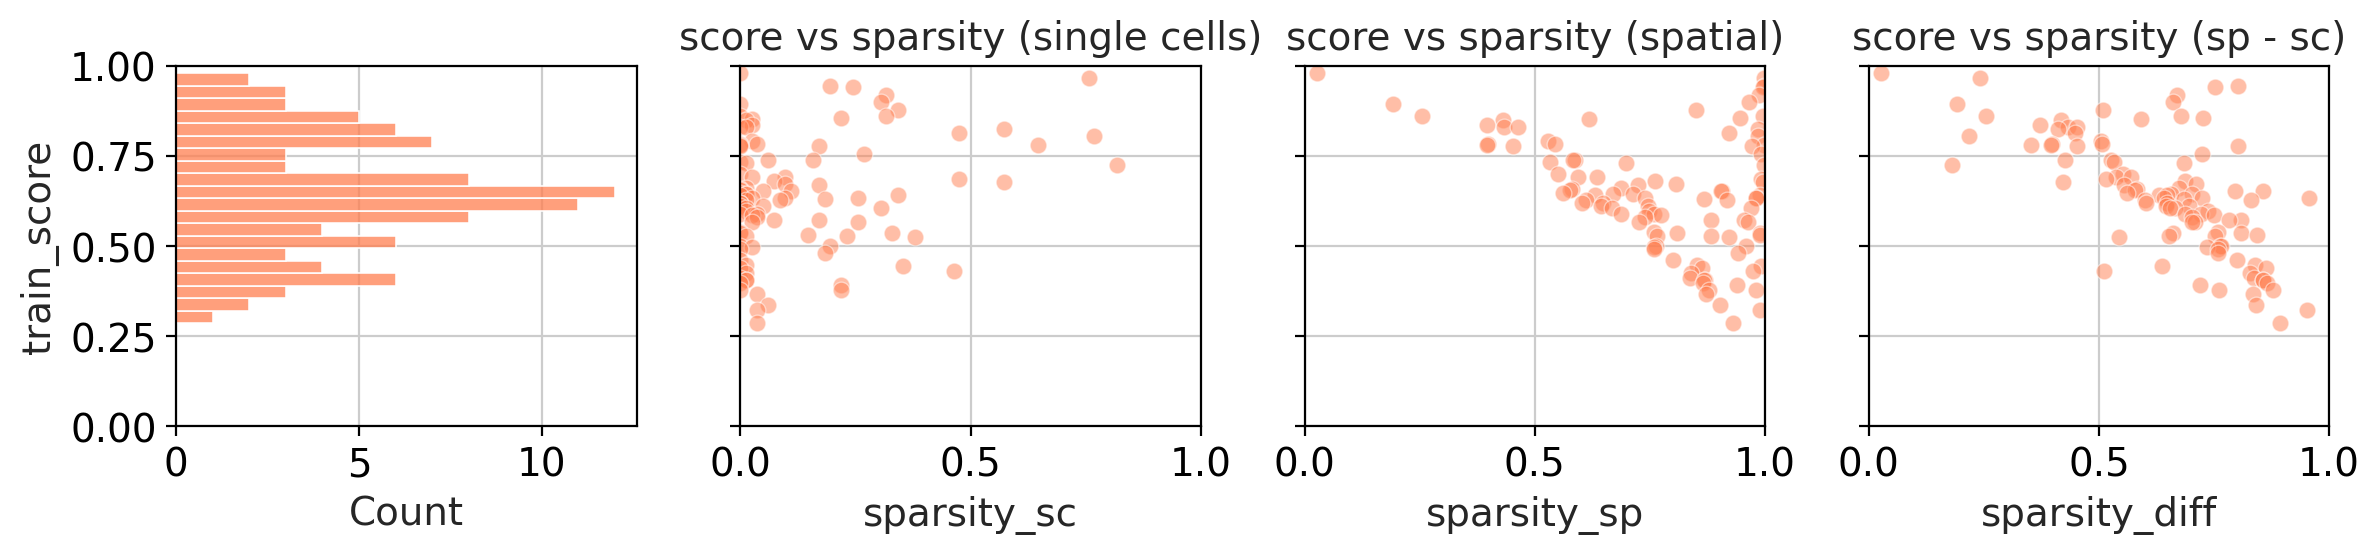

In [38]:
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

In [37]:
tg.plot_cell_annotation_sc(adata_sp, list(pd.unique(adata_sc.obs[col_cell_type])),perc=0.02)

StopIteration: 

In [36]:
ad_map

AnnData object with n_obs × n_vars = 82 × 312393
    obs: 'cell_type', 'cluster_density'
    var: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_

In [45]:
cr.pl.plot_integration_spatial(
                adata_sp, adata_sp_new=None, adata_sc=adata_sc,
                col_cell_type=[col_cell_type, "leiden"],
                ad_map=ad_map, df_compare=None, plot_genes=None)

StopIteration: 

In [48]:
import corescpy as cr

In [5]:
s.plot_spatial()

<Axes: title={'center': 'Annotation'}, xlabel='spatial1', ylabel='spatial2'>

In [40]:
 df_compare = tg.compare_spatial_geneexp(adata_sp_new, adata_sp, adata_sc)

NameError: name 'adata_sp_new' is not defined

In [39]:
adata_sp_new = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)

ValueError: The two AnnDatas need to have same `obs` index.

In [20]:
adata_sp

AnnData object with n_obs × n_vars = 312393 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', 'ce

In [25]:
ad_map.obs

,cell_type,cluster_density
0,stromal cell,0.165389
1,mesodermal cell,0.158139
2,enterocyte of colon,0.138229
3,enteric smooth muscle cell,0.051152
4,progenitor cell,0.036155
5,glial cell,0.035476
6,transit amplifying cell,0.031167
7,stem cell,0.026209
8,pericyte,0.025881
9,naive B cell,0.022247


In [26]:
ad_map

AnnData object with n_obs × n_vars = 82 × 312393
    obs: 'cell_type', 'cluster_density'
    var: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_

In [7]:
set(np.unique(pd.DataFrame(adata_sc.uns["rank_genes_groups_cell_type"][
            "names"]).melt().value.values)).intersection(set(sdata.var_names))

AttributeError: 'SpatialData' object has no attribute 'var_names'

In [ ]:
key_cell_type, col_ann = None, "leiden_sub"
for s in selves:
    s.plot_spatial(color=col_ann)

In [ ]:
s.annotate_clusters(file_ann, col_cell_type="leiden", col_annotation="Annotation")
s.annotate_clusters(file_ann, col_cell_type="leiden_subcluster", col_annotation="Annotation_Subcluster")
s.plot_spatial(color="Annotation_Subcluster")

In [ ]:
dff = pd.concat([pd.Series(marker_genes_dict[x]).to_frame("Marker")
                 for x in marker_genes_dict], keys=marker_genes_dict)
dff[dff.Marker.isin(self.rna.var_names)]

In [ ]:
adf = pd.read_excel(file_ann)
adf


i = 0
self = selves[i]
self.add_image(paths_he[i], name="H_E", file_align=paths_he_align[i])